In [61]:
#using Pkg
#Pkg.add("SpecialFunctions")

In [1]:
using Symbolics
using Plots
using SpecialFunctions

#custom dependencies
include("integration.jl")
include("derivatives.jl")
include("error_metrics.jl")
include("interpolations.jl")
include("initial_value_problems.jl")
include("root_finding_algorithms.jl")
include("initial_value_problems_system.jl")

RKsystem (generic function with 1 method)

1. [Numeric Differenciation](#1-numeric-differenciation)
2. [Numeric Integration](#2-numeric-integration)
3. [Solve ODE](#3-solving-initial-value-problems)

-------------------

# 1. Numeric differenciation 

### a. Using three and five points differenciation formula, find the value of the derivative of:

#### i) y = $tan(\frac{x}{3})$ at x = 3, with a step size of h = 0.1

In [2]:
function f1(x)
    return tan(x/3)
end

f1 (generic function with 1 method)

In [3]:
x1 = 3.0
h1 = 0.1

df1_3 = three_point_numeric_diff_middle(f1, x1, h1)
df1_5 = five_point_numeric_diff_middle(f1, x1, h1)

# print results
println("First function")
println("3 point numeric diff: ", df1_3)
println("5 point numeric diff: ", df1_5)
println("Difference between both:", error_metric(df1_3, df1_5, true))

First function
3 point numeric diff: 1.1453517333306606
5 point numeric diff: 1.1417911815759805
Difference between both:0.0035605517546801746


#### ii) y = $e^{x} + x$ at x = 2, with a step size of h = 0.2

In [4]:
function f2(x)
    return exp(x) + x
end

f2 (generic function with 1 method)

In [5]:
x2 = 2.0
h2 = 0.2

df2_3 = three_point_numeric_diff_middle(f2, x2, h2)
df2_5 = five_point_numeric_diff_middle(f2, x2, h2)

println("Second function")
println("3 point numeric diff: ", df2_3)
println("5 point numeric diff: ", df2_5)
println("Difference between both:", error_metric(df2_3, df2_5, true))

Second function
3 point numeric diff: 8.438415087552942
5 point numeric diff: 8.388660134967886
Difference between both:0.049754952585056245


### b. Calculate first derivative of $y = cos(x)$ with $x = \frac{\pi}{4}$ using the Richardson extrapolation method with a step size of $h_{1} = \frac{\pi}{3}$ and $h_{2} = \frac{\pi}{6}$. Using the three middle points formula for inferring the derivative inside the Richardson extrapolation method.

In [6]:
function f3(x)
    return cos(x)
end

f3 (generic function with 1 method)

In [7]:
x3 = pi/4
h3_1 = pi/3
h3_2 = pi/6

#richardson depth
ndepth = 5

approx1 = general_richardson(f3, x3, h3_1, ndepth, three_point_numeric_diff_middle)
approx2 = general_richardson(f3, x3, h3_2, ndepth, three_point_numeric_diff_middle)
println("\n===========Richardson extrapolation =======")
println("Approximation h1: ", approx1)
println("Approximation h2: ", approx2)
println("Difference between both:", error_metric(approx1, approx2, true))


===========Richardson extrapolation =======
Approximation h1: -0.7071067811865213
Approximation h2: -0.7071067811865469
Difference between both:2.5646151868841116e-14


### c. Determine the inflection points of the normal distribution function defined as follows:

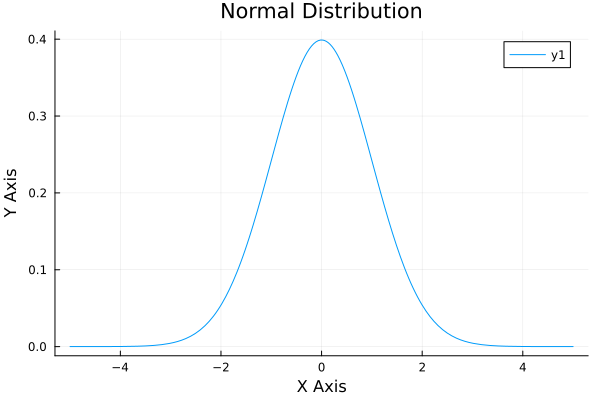

In [8]:
function normal_distribution(x)
    return (1/sqrt(2*pi))*exp(-x^2/2)
end

plot(normal_distribution, legend=true, title="Normal Distribution", xlabel="X Axis", ylabel="Y Axis")

We built functions to get the nth-derivative of a function by interpolating the sampled points from the function _(with cubic splines and cubic lagrange polynomials)_ and then derivating the interpolating function.


1. First sample the original function as follows:

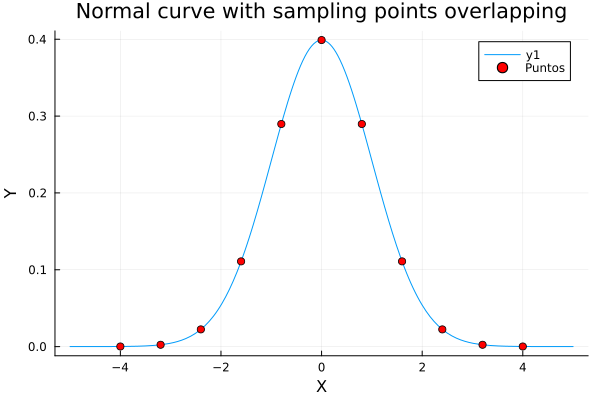

In [9]:
step = 0.8
start = -4
stop = 4

x_sample = [i for i in start:step:stop]
y_sample = [normal_distribution(x) for x in x_sample]
sampled_points = [[x, y] for (x, y) in zip(x_sample, y_sample)]


plot(normal_distribution,
     title="Normal curve with sampling points overlapping",
     xlabel="X",
     ylabel="Y",
     legend=true)

scatter!(x_sample,
         y_sample,
         label="Puntos",
         color=:red)   


2. Now built functions to get the nth-derivative of a function by interpolating the sampled points from the function (with cubic splines and cubic lagrange polynomials).

In [10]:
function get_nth_derivarive_lagrange(sampling_points::Vector{Vector{Float64}},
                                     numeric_diff_algoritm::Function,
                                     fn::Function,
                                     n::Int,
                                     nresample::Int,
                                     h::Float64, 
                                     niters::Int)
    """
        Given a set of points, this function calculates the nth derivative of the function that interpolates the points.

        Arguments:
        ----------------
            sampling_points: Vector of points [x,y] to interpolate.
            numeric_diff_algoritm: function used to calculate the derivative.
            fn: assistant function to calculate the derivative, some algorithms need an extra function to calculate the derivative.

            n: nth derivative to calculate.
            h: step to calculate the derivative.
        
        Returns:
        ----------------
            y: interpolated value.
    """

    if n < 1
        error("The nth derivative must be greater than 0")
    end

    xmin = minimum([p[1] for p in sampling_points])
    xmax = maximum([p[1] for p in sampling_points])
    #println("sampling_points: ", sampling_points)
    
    for i in 1:n
        
        #interpolate the points
        fn = (x) -> interpolate_point(sampling_points, x)
        
        #build the x x_domain to sample the points
        x_domain = [x for x in range(start=xmin, stop=xmax, length=nresample)] 
        #println("x_domain: ", x_domain)

        #resample the points 
        sampling_points = [[x, fn(x)] for x in x_domain]
        #println("sampling_points1: ", sampling_points)

        #calculate the derivative of the points
        derivarives::Vector{Vector{Float64}} = []

        for j in 1:length(x_domain)
        
            x = x_domain[j]

            #if the point + h is greater than the maximum x value then use the three point method
            #to avoid the error of the points being out of the domain
            if x + h > xmax
                #computes the derivative of the last points
                last_3_points = sampling_points[j-2:j]
                push!(derivarives, [x, three_point_numeric_diff_extremes(last_3_points, h)])
                println(j)

            #if the point - h is less than the minimum x value then use the richardson method
            #which is more accurate
            else
                push!(derivarives, [x, numeric_diff_algoritm(fn, x, h, niters)])
            end
        
        end
        sampling_points = derivarives

        #println("sampling_points2: ", sampling_points)
    end

    return sampling_points
    
end

get_nth_derivarive_lagrange (generic function with 1 method)

In [11]:
function get_nth_derivarive_cubic(sampling_points::Vector{Vector{Float64}},
                                  numeric_diff_algoritm::Function,
                                  fn::Function,
                                  n::Int,
                                  h::Float64, 
                                  nresample::Int, 
                                  niters::Int)
    """
        Given a set of points, this function calculates the nth derivative of the function that interpolates the points.

        Arguments:
        ----------------
            sampling_points: Vector of points [x,y] to interpolate.
            numeric_diff_algoritm: function used to calculate the derivative.
            fn: assistant function to calculate the derivative, some algorithms need an extra function to calculate the derivative.

            n: nth derivative to calculate.
            h: step to calculate the derivative.
        
        Returns:
        ----------------
            y: interpolated value.
    """

    if n < 1
        error("The nth derivative must be greater than 0")
    end

    @variables x_sym
    xmin = minimum([p[1] for p in sampling_points])
    xmax = maximum([p[1] for p in sampling_points])
    
    for i in 1:n
        #given the points try to approximate the function with a cubic spline
        polynomials = build_cubic_splines(sampling_points, x_sym)
        fn = (x) -> interpolate(polynomials, x)
        
        #build the x_domain to sample the points
        x_domain = [x for x in range(start=xmin, stop=xmax, length=nresample)]
        
        #resample the points to get a better approximation using the cubic spline
        #update the sampling_points
        sampling_points = [[x, fn(x)] for x in x_domain]
    
        #calculate the derivative of the points
        derivative::Vector{Vector{Float64}} = []
    
        for j in 1:length(x_domain)

            x = x_domain[j]
            if x + h > xmax
                #computes the derivative of the last points
                last_3_points = sampling_points[j-2:j]
                push!(derivative, [x, three_point_numeric_diff_extremes(last_3_points, h)])
            else
                push!(derivative, [x, numeric_diff_algoritm(fn, x, h, niters)])
            end
        end

        sampling_points = derivative
    end

    return sampling_points, build_cubic_splines(sampling_points, x_sym)
end

get_nth_derivarive_cubic (generic function with 1 method)

3. Obtain the nth-derivative of the normal distribution function, with n = 2, using the functions built in the previous step, particularly with the cubic lagrange polynomials.

20
20


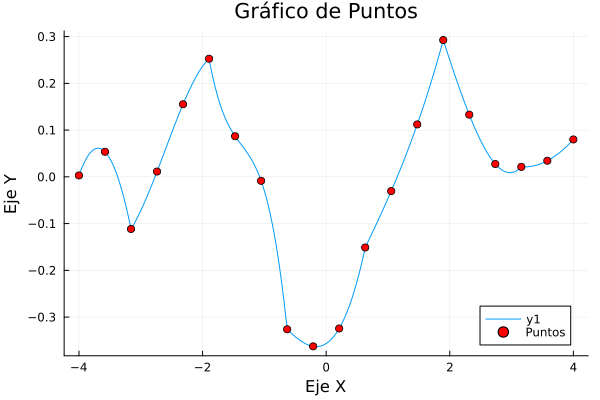

In [12]:
#degree of the derivative
n = 2
h = 0.25
nresample = 20
niters = 5

nth_derivative = get_nth_derivarive_lagrange(sampled_points, richardson, normal_distribution, n, nresample, h, niters)
nth_derivative_x = [nth_derivative[i][1] for i in 1:length(nth_derivative)]
nth_derivative_y = [nth_derivative[i][2] for i in 1:length(nth_derivative)]

plot_polynomiun(nth_derivative_x, nth_derivative_y, 0.025)


4. Obtain the nth-derivative of the normal distribution function, with n = 2, using the functions built in the previous step, particularly with the cubic splines.

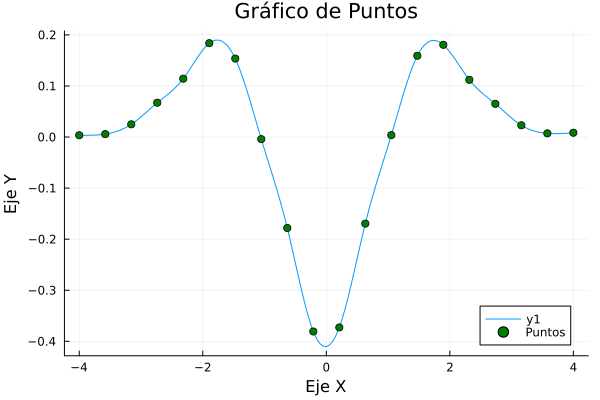

In [13]:
#degree of the derivative
n = 2
h = 0.25
resample = 20
niters = 5

nth_derivative, polynomials = get_nth_derivarive_cubic(sampled_points, richardson, normal_distribution, n, h, resample, niters)
nth_derivative_x = [nth_derivative[i][1] for i in 1:length(nth_derivative)]
nth_derivative_y = [nth_derivative[i][2] for i in 1:length(nth_derivative)]

#used for plotting the interpolation of the points given by the get_nth_derivarive_cubic function
x_domain = [i for i in start:0.05:stop]
y_range  = [interpolate(polynomials, x) for x in x_domain]

plot(x_domain, y_range, legend=true, title="Gráfico de Puntos", xlabel="Eje X", ylabel="Eje Y")
scatter!(nth_derivative_x, nth_derivative_y, label="Puntos", color=:green)

5. Using the cubic splines, find the inflection points of the normal distribution function by bisection method, 
over the interval.

In [14]:
fn = (x) -> interpolate(polynomials, x)
low = -2.0
high = 2.0
tol = 0.0001
max_iter = 100
target_value = 0.0

x1, niters1 = bisection(fn, low, high, tol, max_iter, target_value)

(-1.06298828125, 13)

In [15]:
low = 0.0
high = 2.0
tol = 0.0001
max_iter = 100
target_value = 0.0

x2, niters2 = bisection(fn, low, high, tol, max_iter, target_value)

(1.04345703125, 12)

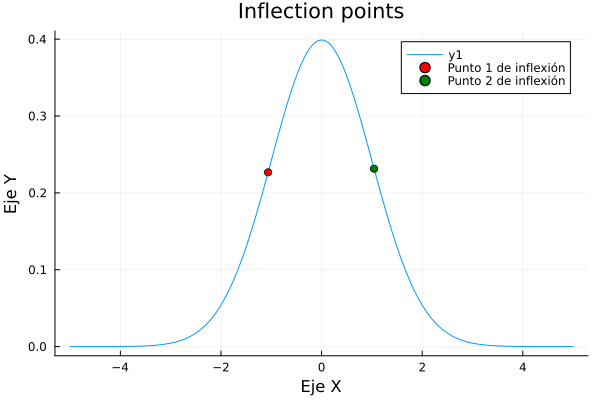

In [16]:
plot(normal_distribution, legend=true, title="Inflection points", xlabel="Eje X", ylabel="Eje Y")
scatter!([x1], [normal_distribution(x1)], label="Punto 1 de inflexión", color=:red)
scatter!([x2], [normal_distribution(x2)], label="Punto 2 de inflexión", color=:green)

-----------
# 2. Numeric integration

### a. Evaluate this integral $\int_{0}^{\pi/2} (6 + 3cos(x)) dx$

#### i. Analytic integration

In [17]:
f4 = x -> 6 + 3*cos(x)
int_f4 = x -> 6*x + 3*sin(x)

start = 0.0
stop = π/2
exact_value = int_f4(stop) - int_f4(start)
print("The exact value of the integral between  [$(start), $(stop)] is: ", exact_value)


The exact value of the integral between  [0.0, 1.5707963267948966] is: 12.42477796076938

#### ii. Trapezoidal rule, with only one application

In [18]:
trapezoidal_approx_f = trapezoidal_approx(f4, start, stop)
abs_error = error_metric(trapezoidal_approx_f, exact_value, true)
relative_error = error_metric(trapezoidal_approx_f, exact_value, false)

print("\nThe trapezoidal approximation of the integral of f between [$(start), $(stop)] is: ", trapezoidal_approx_f)
print("\nThe absolute error of the trapezoidal approximation is: ", abs_error)
print("\nThe relative error of the trapezoidal approximation is: $(relative_error)%")



The trapezoidal approximation of the integral of f between [0.0, 1.5707963267948966] is: 11.780972450961723
The absolute error of the trapezoidal approximation is: 0.643805509807656
The relative error of the trapezoidal approximation is: 0.0518162587565299%

#### iii. Multiple application of the trapezoidal rule, with $n=2$ and $n=4$

In [19]:
n = 2

trapezoidal_composite_f = trapezoidal_composite(f4, start, stop, n)
abs_error = error_metric(trapezoidal_composite_f, exact_value, true)
relative_error = error_metric(trapezoidal_composite_f, exact_value, false)

print("\nThe trapezoidal composite n = $(n), approximation of the integral of f between [$(start), $(stop)] is: ", trapezoidal_composite_f)
print("\nThe absolute error of the trapezoidal composite approximation is: ", abs_error)
print("\nThe relative error of the trapezoidal composite approximation is: $(relative_error)%")


The trapezoidal composite n = 2, approximation of the integral of f between [0.0, 1.5707963267948966] is: 12.268956307674939
The absolute error of the trapezoidal composite approximation is: 0.1558216530944403
The relative error of the trapezoidal composite approximation is: 0.012541202232059151%

In [20]:
n = 4

trapezoidal_composite_f = trapezoidal_composite(f4, start, stop, n)
abs_error = error_metric(trapezoidal_composite_f, exact_value, true)
relative_error = error_metric(trapezoidal_composite_f, exact_value, false)

print("\nThe trapezoidal composite n = $(n), approximation of the integral of f between [$(start), $(stop)] is: ", trapezoidal_composite_f)
print("\nThe absolute error of the trapezoidal composite approximation is: ", abs_error)
print("\nThe relative error of the trapezoidal composite approximation is: $(relative_error)%")


The trapezoidal composite n = 4, approximation of the integral of f between [0.0, 1.5707963267948966] is: 12.386125363687706
The absolute error of the trapezoidal composite approximation is: 0.03865259708167379
The relative error of the trapezoidal composite approximation is: 0.003110928597977159%

#### iv. 1/3 Simpson's rule, with only one application.

In [21]:
simpson_rule_approx_f = simpson_rule_approx(f4, start, stop)
abs_error = error_metric(simpson_rule_approx_f, exact_value, true)
relative_error = error_metric(simpson_rule_approx_f, exact_value, false)

print("\nThe simpson rule approximation of the integral of f between [$(start), $(stop)] is: ", simpson_rule_approx_f)
print("\nThe absolute error of the simpson rule approximation is: ", abs_error)
print("\nThe relative error of the simpson rule approximation is: $(relative_error)%")


The simpson rule approximation of the integral of f between [0.0, 1.5707963267948966] is: 12.43161759324601
The absolute error of the simpson rule approximation is: 0.006839632476630442
The relative error of the simpson rule approximation is: 0.0005504832760976689%

#### v. Multiple application of the 1/3 Simpson's rule, with $n=4$

In [22]:
n = 4

simpson_composite_f = simpson_composite(f4, start, stop, n)
abs_error = error_metric(simpson_composite_f, exact_value, true)
relative_error = error_metric(simpson_composite_f, exact_value, false)

print("\nThe simpson composite n = $(n), approximation of the integral of f between [$(start), $(stop)] is: ", simpson_composite_f)
print("\nThe absolute error of the simpson composite approximation is: ", abs_error)
print("\nThe relative error of the simpson composite approximation is: $(relative_error)%")



The simpson composite n = 4, approximation of the integral of f between [0.0, 1.5707963267948966] is: 12.425181715691961
The absolute error of the simpson composite approximation is: 0.00040375492258171164
The relative error of the simpson composite approximation is: 3.249594671683854e-5%

#### vi. 3/8 Simpson's rule, with only one application.

In [23]:
simpson_fraction_rule_approx_f = simpson_fraction_rule_approx(f4, start, stop)
abs_error = error_metric(simpson_fraction_rule_approx_f, exact_value, true)
relative_error = error_metric(simpson_fraction_rule_approx_f, exact_value, false)

print("\nThe simpson fraction rule approximation of the integral of f between [$(start), $(stop)] is: ", simpson_fraction_rule_approx_f)
print("\nThe absolute error of the simpson fraction rule approximation is: ", abs_error)
print("\nThe relative error of the simpson fraction rule approximation is: $(relative_error)%")


The simpson fraction rule approximation of the integral of f between [0.0, 1.5707963267948966] is: 12.427792730712216
The absolute error of the simpson fraction rule approximation is: 0.0030147699428368924
The relative error of the simpson fraction rule approximation is: 0.0002426417560423115%

#### vii. Multiple application of the 3/8 Simpson's rule, with $n=6$

In [24]:
n = 6

simpson_fraction_composite_f = simpson_fraction_composite(f4, start, stop, n)
abs_error = error_metric(simpson_fraction_composite_f, exact_value, true)
relative_error = error_metric(simpson_fraction_composite_f, exact_value, false)

print("\nThe simpson fraction composite n = $(n), approximation of the integral of f between [$(start), $(stop)] is: ", simpson_fraction_composite_f)
print("\nThe absolute error of the simpson fraction composite approximation is: ", abs_error)
print("\nThe relative error of the simpson fraction composite approximation is: $(relative_error)%")


The simpson fraction composite n = 6, approximation of the integral of f between [0.0, 1.5707963267948966] is: 12.42478013952675
The absolute error of the simpson fraction composite approximation is: 2.1787573700748908e-6
The relative error of the simpson fraction composite approximation is: 1.7535583951312525e-7%

### b. The quantity of mass (in milligrams) transported along a pipe during a time period starting at $t_1(min)$ and ending at $t_2(min)$, is calculated by the following integral: $M = \int_{t_1}^{t_2} Q(t)c(t) dt$

Where $Q(t)$ is the volumetric flow rate (in $m^3/min$) and $c(t)$ is the concentration of the transported material (in $mg/m^3$). The values of $Q(t)$ and $c(t)$ are given by the following set of equations:

$$Q(t) = 9 + 5cos^2(0.4)t$$
$$c(t) = 5e^{-0.5t} + 2e^{-0.15t}$$

Determine the transported mass at $t_1 = 2$ and $t_2 = 8$ using Romberg method with a tolerance of at least $0.1\%$

#### i. Analytic integration, get the exact value of the integral

In [25]:
qt = t -> 9 + 5*(cos(0.4)^2)*t
ct = t -> (5*exp(-0.5*t)) + 2*exp(0.15*t)
mt = t -> qt(t)*ct(t)

#156 (generic function with 1 method)

In [26]:
mt_int = t -> exp(-0.5*t)*(-42.4177*t + exp(0.65*t)*(56.5569*t - 257.046) - 174.835)

#158 (generic function with 1 method)

In [27]:
start_t = 2.0 
end_t = 8.0
exact_value = mt_int(end_t) - mt_int(start_t)

println("The exact value of the integral between  [$(start_t), $(end_t)] is: ", exact_value)

The exact value of the integral between  [2.0, 8.0] is: 929.1794683523293


#### ii. Romberg integration, for finding the value of the integral with tolerance of $0.1\%$

In [28]:
n = 1
romberg_approx_mt = romberg_approx(mt, start_t, end_t, n)
abs_error = error_metric(romberg_approx_mt, exact_value, true)
relative_error = error_metric(romberg_approx_mt, exact_value, false)

print("\nThe romberg approximation of the integral of mt between [$(start_t), $(end_t)] is: ", romberg_approx_mt)
print("\nThe absolute error of the romberg approximation is: ", abs_error)
print("\nThe relative error of the romberg approximation is: $(relative_error)%")


The romberg approximation of the integral of mt between [2.0, 8.0] is: 929.594943800041
The absolute error of the romberg approximation is: 0.41547544771174216
The relative error of the romberg approximation is: 0.0004471423033576984%

### c. The free fall equation for a skydiver is given by: $v(t) = \frac{gm}{c}(1 - e^{\frac{-ct}{m}})$

Where $g = 9.81 m/s^2$ is the gravitational acceleration, $m = 80 kg$ is the mass of the skydiver and $c = 10 kg/s$ is the drag coefficient. Determine the distance traveled by the skydiver during the first 8 seconds of free fall. Ensure that the error is less than $0.1\%$.

In [29]:
g = 9.81 #m/s^2
c = 10.0 #kg/s
start_t = 0.0 #s
end_t = 8.0 #s
m = 80 #kg

80

In [30]:
vt = t -> (g*m/c)*(1 - exp(-(c/m)*t))
xt = t -> (m*g) * (m * exp(-(c/m)*t) + c*t)/c^2

exact_value = xt(end_t) - xt(start_t)
println("The exact value of the integral between  [$(start_t), $(end_t)] is: ", exact_value)

The exact value of the integral between  [0.0, 8.0] is: 230.96942834507843


In [31]:
n = 1
romberg_approx_xt = romberg_approx(vt, start_t, end_t, n)
abs_error = error_metric(romberg_approx_xt, exact_value, true)
relative_error = error_metric(romberg_approx_xt, exact_value, false)

print("\nThe romberg approximation of the integral of vt between [$(start_t), $(end_t)] is: ", romberg_approx_xt)
print("\nThe absolute error of the romberg approximation is: ", abs_error)
print("\nThe relative error of the romberg approximation is: $(relative_error)%")


The romberg approximation of the integral of vt between [0.0, 8.0] is: 230.83562234650046
The absolute error of the romberg approximation is: 0.13380599857796938
The relative error of the romberg approximation is: 0.0005793234175479595%

In [32]:
adaptative_integral_approx = adaptative_integral(vt, start_t, end_t, 0.01)
abs_error = error_metric(adaptative_integral_approx, exact_value, true)
relative_error = error_metric(adaptative_integral_approx, exact_value, false)

print("\nThe adaptative integral approximation of the integral of vt between [$(start_t), $(end_t)] is: ", adaptative_integral_approx)
print("\nThe absolute error of the adaptative integral approximation is: ", abs_error)
print("\nThe relative error of the adaptative integral approximation is: $(relative_error)%")


The adaptative integral approximation of the integral of vt between [0.0, 8.0] is: 230.96942708919102
The absolute error of the adaptative integral approximation is: 1.2558874118440144e-6
The relative error of the adaptative integral approximation is: 5.437461662535112e-9%

--------
# 3. Solving Initial Value Problems

#### a. 

In [33]:
k = 0.06
y′ = (x, y) -> -k*sqrt(y)

#164 (generic function with 1 method)

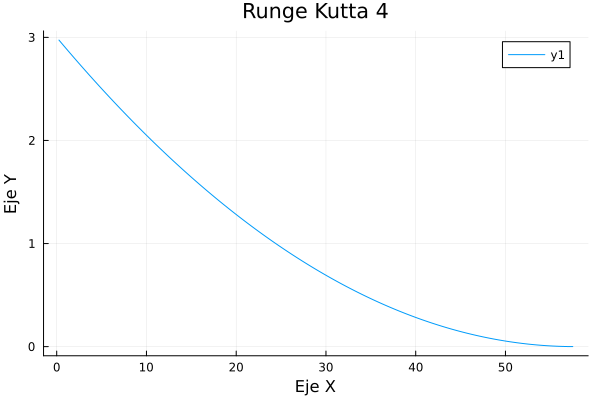

In [34]:
start_t = 0.0
initial_volume = 3.0
step_size = 0.25
tol = 0.0002

x_solution1, y_solution1 = runge_kutta_4(y′, start_t, initial_volume, step_size, tol)
plot(x_solution1, y_solution1, legend=true, title="Runge Kutta 4", xlabel="Eje X", ylabel="Eje Y")

Cubic spline interpolation of the solution

In [35]:
@variables t_sym
solution1 = [[x_solution1[i], y_solution1[i]] for i in 1:length(x_solution1)]
polynomials2 = build_cubic_splines(solution1, t_sym)
fn2 = (t) -> interpolate(polynomials2, t)

#168 (generic function with 1 method)

Bisection method for finding the roots of the solution

In [36]:
high = maximum(x_solution1)
low = high - 0.5
tol = 0.001
max_iter = 1000
target_value = 0.0

x1, niters1 = bisection(fn2, low, high, tol, max_iter, target_value)

(57.25, 1)

In [37]:
fn2(57.25)

0.00021206252714023321

#### b. Find the solution of the following initial value problem keeping in mind that:
$0 \leq x \leq 1, h = 0.05$ and $y(0) = 1$. ***Plot all the results in the same figure***

In [2]:
x0 = 0.0
y0 = 1.0
lower_bound = 0.0
upper_bound = 1.0
h = 0.05
tol = 1e-4

y′ = (x, y) -> (1 + 4*x)*sqrt(y)

#116 (generic function with 1 method)

In [3]:
#parade conditions for the runge_kutta methods
parade_condition = (x, x_new, y, y_new) -> (x_new > upper_bound)

#118 (generic function with 1 method)

##### i. Analitic solution 

##### ii. Euler's method

In [41]:
xsol1, ysol1 = euler_method(y′, x0, y0, lower_bound, upper_bound, h) 

([0.0, 0.05, 0.1, 0.15000000000000002, 0.2, 0.25, 0.30000000000000004, 0.35000000000000003, 0.4, 0.45  …  0.55, 0.6000000000000001, 0.65, 0.7000000000000001, 0.75, 0.8, 0.8500000000000001, 0.9, 0.9500000000000001, 1.0], [1.0, 1.05, 1.1114817045957577, 1.1852804874618674, 1.2723769576530064, 1.3738966767079237, 1.4911100153988732, 1.6254321326630319, 1.778423056283839, 1.9517878440903509  …  2.3671857635246942, 2.613356345735957, 2.888176283862304, 3.1940797189478527, 3.5336474998900638, 3.909607471157754, 4.3248347456449405, 4.782351960281958, 5.285329513159734, 5.837085781776595])

##### iii. Midpoint method

In [42]:
xsol2, ysol2 = runge_kutta_2(y′, x0, y0, h, tol, parade_condition=parade_condition)

([0.05, 0.1, 0.15000000000000002, 0.2, 0.25, 0.3, 0.35, 0.39999999999999997, 0.44999999999999996, 0.49999999999999994, 0.5499999999999999, 0.6, 0.65, 0.7000000000000001, 0.7500000000000001, 0.8000000000000002, 0.8500000000000002, 0.9000000000000002, 0.9500000000000003], [1.0556832560111207, 1.1234364321682957, 1.2042324855408122, 1.2991941681363182, 1.4095940665646465, 1.5368546396426164, 1.6825482529936688, 1.8483972100497539, 2.0362737791694796, 2.248200216832602, 2.4863487870537537, 2.7530417772824833, 3.050751511130949, 3.3821003583053355, 3.749860742122456, 4.156955144978179, 4.606456112106752, 5.101586253935589, 5.64571824730286])

##### iv. Modified Euler's method

In [43]:
xsol3, ysol3 = runge_kutta_3(y′, x0, y0, h, tol, parade_condition=parade_condition)

([0.05, 0.1, 0.15000000000000002, 0.2, 0.25, 0.3, 0.35, 0.39999999999999997, 0.44999999999999996, 0.49999999999999994, 0.5499999999999999, 0.6, 0.65, 0.7000000000000001, 0.7500000000000001, 0.8000000000000002, 0.8500000000000002, 0.9000000000000002, 0.9500000000000003], [1.0557408522978788, 1.12356296854379, 1.204439277953761, 1.2994925254759273, 1.4099953086447863, 1.5373701118460585, 1.6831893374381468, 1.8491753334364989, 2.0372004176724565, 2.249286898492462, 2.487607092173432, 2.7544833373029953, 3.05238800641612, 3.3839435151989408, 3.7519223295720066, 4.159246970953781, 4.60899001998517, 5.104374118970624, 5.648771973263584])

##### v. Runge-Kutta 4th order method

In [44]:
xsol4, ysol4 = runge_kutta_4(y′, x0, y0, h, tol, parade_condition=parade_condition)

([0.05, 0.1, 0.15000000000000002, 0.2, 0.25, 0.3, 0.35, 0.39999999999999997, 0.44999999999999996, 0.49999999999999994, 0.5499999999999999, 0.6, 0.65, 0.7000000000000001, 0.7500000000000001, 0.8000000000000002, 0.8500000000000002, 0.9000000000000002, 0.9500000000000003, 1.0000000000000002], [1.0557562349728131, 1.1235999665239123, 1.2045061941128528, 1.2995999170502786, 1.4101561345207263, 1.5375998456170337, 1.6835060493804999, 1.8495997448412844, 2.037755931054764, 2.249999607131152, 2.488505772257202, 2.7555994257100336, 3.0537555668639023, 3.3855991951911926, 3.7539053102590314, 4.161598911722864, 4.611754999318155, 5.107598572851151, 5.652504632189415, 6.249998177252628])

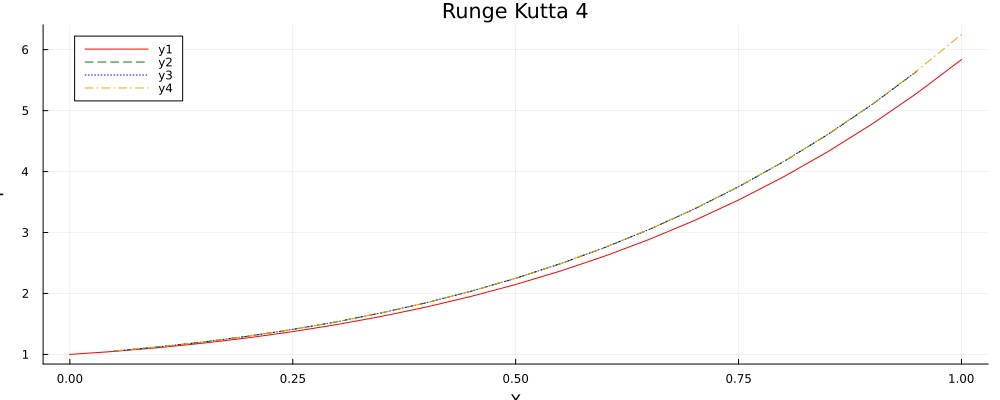

In [45]:
#set plot size

plot(xsol1, ysol1, legend=true, title="Euler Method", xlabel="X", ylabel="Y", color=:red, size=(1000, 400))
plot!(xsol2, ysol2, legend=true, title="Runge Kutta 2", xlabel="X", ylabel="Y", color=:green, linestyle=:dash)
plot!(xsol3, ysol3, legend=true, title="Runge Kutta 3", xlabel="X", ylabel="Y", color=:blue, linestyle=:dot)
plot!(xsol4, ysol4, legend=true, title="Runge Kutta 4", xlabel="X", ylabel="Y", color=:orange, linestyle=:dashdot)

#### c. 

In [5]:
k = 20 #N/m
m = 20 #kg
t0 = 0.0 #s
x0 = 1.0 #m
v0 = 0.0 #m/s
tf = 15.0 #s
cs = [5, 40, 200] #N*s/m

h = 0.01

0.01

In [6]:
parade_condition = (t,x,v) -> (t > tf)
answers = []
xs = []
ts = []

for c in cs 

    let dx, ddx

        dx = (t, x, v_) -> v_
        ddx = (t, x, v_) -> ((-c*v_) -k*x)/m

        push!(answers, RKsystem(dx, ddx, x0, v0, t0, tf, h, parade_condition=parade_condition))

    end

end

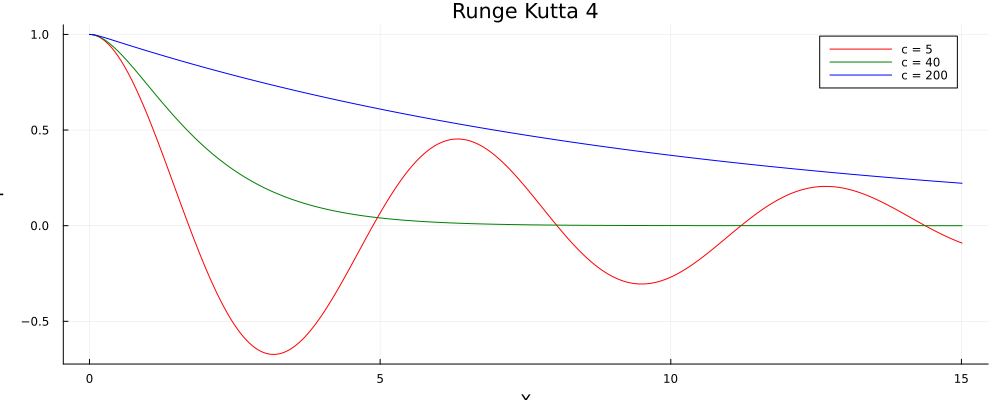

In [69]:
plot(answers[1][1], answers[1][2], legend=true, title="Runge Kutta 4", xlabel="X", ylabel="Y", color=:red, size=(1000, 400), label="c = 5")
plot!(answers[2][1], answers[2][2], legend=true, title="Runge Kutta 4", xlabel="X", ylabel="Y", color=:green, size=(1000, 400), label="c = 40")
plot!(answers[3][1], answers[3][2], legend=true, title="Runge Kutta 4", xlabel="X", ylabel="Y", color=:blue, size=(1000, 400), label="c = 200")

#### d.

In [3]:
k = 0.026 #millones/año
#dp = 

0.026

#### e.

##### i.

In [7]:
#y(x) = e^(0.6 x) (0.783405 - 0.283405 erf(18.8244 - 9.42809 x))
y = (x) -> exp(0.6*x)*(0.783405 - 0.283405*erf(18.8244 - 9.42809*x))

#126 (generic function with 1 method)

In [8]:
h = 0.2
x0 = 0.0 
y0 = 2.0
tol = 1e-5
lower_bound = 0.0
upper_bound = 2.0

y′ = (x, y) -> 4*exp(0.8*x) - 0.5*y 
y = (x) -> exp(-0.5*x)*(3.07692*exp(1.3*x) - 1.07692)

#128 (generic function with 1 method)

In [9]:
xs1, ys1 = runge_kutta_fehlberg(y′, x0, y0, h, upper_bound, tol, true)

#drop the points bigger than 2
ys1 = ys1[1:findfirst(x -> x > 1.9, xs1)]
xs1 = xs1[1:findfirst(x -> x > 1.9, xs1)]

10-element Vector{Float64}:
 0.2
 0.4
 0.6000000000000001
 0.8
 1.0
 1.2
 1.4
 1.5999999999999999
 1.7999999999999998
 1.9999999999999998

In [10]:
parade_condition = (x, x_new, y, y_new) -> (x_new > upper_bound)
xs2, ys2 = runge_kutta_4(y′, x0, y0, h, tol, parade_condition = parade_condition)

#drop the points bigger than 2
ys2 = ys2[1:findfirst(x -> x > 1.9, xs2)]
xs2 = xs2[1:findfirst(x -> x > 1.9, xs2)]

10-element Vector{Float64}:
 0.2
 0.4
 0.6000000000000001
 0.8
 1.0
 1.2
 1.4
 1.5999999999999999
 1.7999999999999998
 1.9999999999999998

14.843919428276376
14.843952149747674


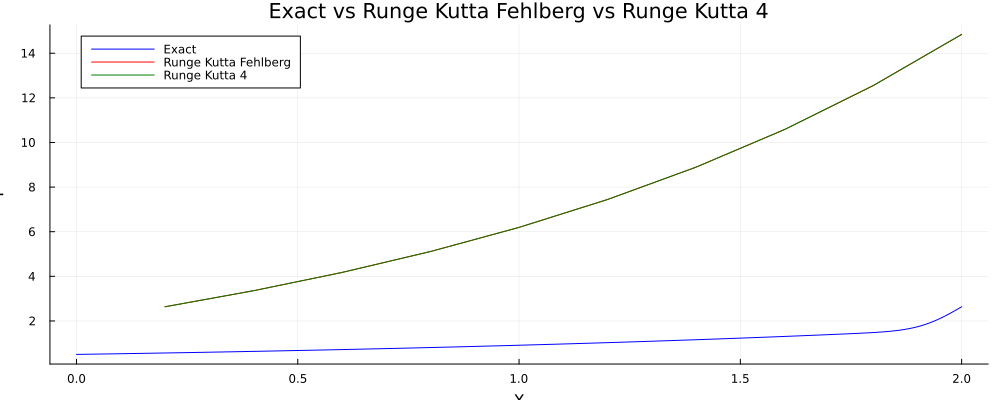

In [12]:
println(ys1[end])
println(ys2[end])

xdom = [x for x in lower_bound:0.01:upper_bound]

plot(xdom, y.(xdom), label = "Exact", legend=true, title="Exact vs Runge Kutta Fehlberg vs Runge Kutta 4", xlabel="X", ylabel="Y", color=:blue, size=(1000, 400))
plot!(xs1, ys1, label = "Runge Kutta Fehlberg", legend=true, title="Exact vs Runge Kutta Fehlberg vs Runge Kutta 4", xlabel="X", ylabel="Y", color=:red, size=(1000, 400))
plot!(xs2, ys2, label = "Runge Kutta 4", legend=true, title="Exact vs Runge Kutta Fehlberg vs Runge Kutta 4", xlabel="X", ylabel="Y", color=:green, size=(1000, 400))

##### ii

In [67]:
lower_bound = 0.0
upper_bound = 4.0
h = 0.25
x0 = 0.0
y0 = 0.5
tol = 1e-5

y′ = (x,y) -> 10*exp(-(x-2)^2/(2*0.075^2)) + 0.6*y

#882 (generic function with 1 method)

In [68]:
xs3, ys3 = runge_kutta_fehlberg(y′, x0, y0, h, 4, tol, true)

#drop the points bigger than 4
ys3 = ys3[1:findfirst(x -> x > 3.99, xs3)]
xs3 = xs3[1:findfirst(x -> x > 3.99, xs3)]

85-element Vector{Float64}:
 0.25
 0.5
 0.75
 1.0
 1.25
 1.5
 1.8411694473328883
 1.958780919225447
 1.9852229437851174
 2.011664968344788
 ⋮
 3.783280613842718
 3.8097226384023886
 3.836164662962059
 3.8626066875217298
 3.8890487120814003
 3.915490736641071
 3.9419327612007415
 3.968374785760412
 3.9948168103200827

In [69]:
parade_condition = (x, x_new, y, y_new) -> (x_new > upper_bound)
xs4, ys4 = runge_kutta_4(y′, x0, y0, h, tol, parade_condition = parade_condition)

#drop the points bigger than 4
ys4 = ys4[1:findfirst(x -> x > 3.99, xs4)]
xs4 = xs4[1:findfirst(x -> x > 3.99, xs4)]

16-element Vector{Float64}:
 0.25
 0.5
 0.75
 1.0
 1.25
 1.5
 1.75
 2.0
 2.25
 2.5
 2.75
 3.0
 3.25
 3.5
 3.75
 4.0

11.06744269211494311.721204146882739

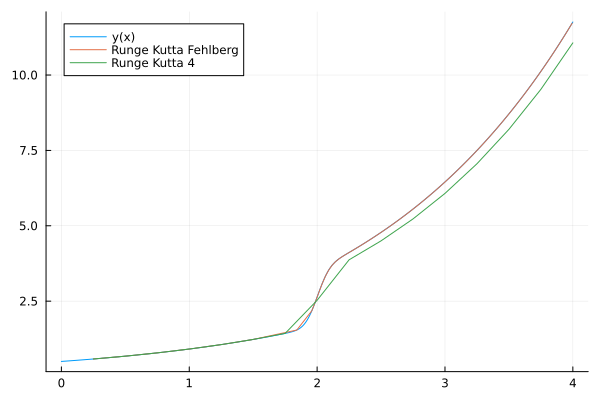

In [72]:
domx = [x for x in 0:0.01:4]
print(ys4[end])
print(ys3[end])

plot(domx, y.(domx), label="y(x)", legend=true)
plot!(xs3, ys3, label="Runge Kutta Fehlberg", legend=true)
plot!(xs4, ys4, label="Runge Kutta 4", legend=true)
